In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import mplfinance as mpf
import talib
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
from sklearn.metrics import mean_squared_error

symbol = 'RNDRUSDT'
client = Client("qycthSI8s5HH0b95MxH3lFKPPUeZu8mCSgztp00x2d7SdHmfOp2U9qBeCCbxPyDg", 
                "zeJqYkyWzBIdGDMmyfUnofQiThirgEgOCDYvS3rzcq4yle1afD7YEQkciCI43yNs")

#######################################################################################

timeframe='30m'
backcandles = 100 
historical_data = client.get_historical_klines(symbol, timeframe)
data = pd.DataFrame(historical_data)
data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
data['Open Time'] = pd.to_datetime(data['Open Time']/1000, unit='s')
data['Close Time'] = pd.to_datetime(data['Close Time']/1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, axis=1)

# Adding indicators
def get_bollinger_bands(df):
    mult = 2.0
    length = 20
    close = df['Close']
    basis = talib.SMA(close, length)
    dev = mult * talib.STDDEV(close, length)
    df['upper'] = basis + dev
    df['lower'] = basis - dev
    return df

data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=50)
data['EMAS']=ta.ema(data.Close, length=200)
data['macd'], data['macd_signal'], data['macd_hist'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data=get_bollinger_bands(data)
data['TARGET'] = data['Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Open Time','Close Time','Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume','Number of Trades',
          'Ignore','index'], axis=1, inplace=True)
cantidad_campos_entrenar=len(data.columns)-1
data_set = data
pd.set_option('display.max_columns', None)
data_set.tail(30)

,Open,High,Low,Close,Volume,RSI,EMAF,EMAM,EMAS,macd,macd_signal,macd_hist,upper,lower,atr,TARGET
770,2.279,2.279,2.258,2.268,275264.84,51.962503,2.264966,2.242508,2.229482,0.006893,0.008948,-0.002056,2.307190,2.235510,0.029698,2.248
771,2.269,2.270,2.240,2.248,143943.35,47.763922,2.263350,2.242723,2.229666,0.004777,0.008114,-0.003337,2.306941,2.232759,0.029720,2.228
772,2.250,2.250,2.222,2.228,478670.50,43.958373,2.259983,2.242146,2.229650,0.001469,0.006785,-0.005316,2.305527,2.227273,0.029597,2.241
773,2.229,2.249,2.218,2.241,158471.75,46.904501,2.258175,2.242101,2.229763,-0.000102,0.005408,-0.005510,2.303177,2.224823,0.029697,2.227
774,2.243,2.249,2.227,2.227,131190.97,44.222074,2.255206,2.241509,2.229735,-0.002449,0.003836,-0.006285,2.304670,2.219930,0.029147,2.213
775,2.228,2.235,2.199,2.213,884088.81,41.668855,2.251187,2.240391,2.229569,-0.005376,0.001994,-0.007370,2.307743,2.213057,0.029637,2.226
776,2.214,2.252,2.214,2.226,252541.49,44.837486,2.248788,2.239826,2.229533,-0.006572,0.000281,-0.006852,2.308645,2.210655,0.030306,2.233
777,2.225,2.236,2.200,2.233,407528.42,46.513708,2.247284,2.239559,2.229568,-0.006875,-0.001150,-0.005724,2.307079,2.207821,0.030712,2.211
778,2.232,2.232,2.206,2.211,292721.26,42.196059,2.243829,2.238439,2.229383,-0.008789,-0.002678,-0.006111,2.303668,2.202832,0.030447,2.246
779,2.210,2.260,2.203,2.246,758804.95,50.092646,2.244035,2.238735,2.229548,-0.007397,-0.003622,-0.003775,2.300349,2.202651,0.032344,2.219


In [11]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
# multiple feature from data provided to the model
X = []
backcandles = 100
for j in range(cantidad_campos_entrenar):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])
#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
# split data into train test sets
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]


In [12]:
np.random.seed(10)
lstm_input = Input(shape=(backcandles, cantidad_campos_entrenar), name='lstm_input')
lstm_layer1 = LSTM(150, return_sequences=True, name='lstm_layer1')(lstm_input)
lstm_layer2 = LSTM(150, name='lstm_layer2')(lstm_layer1)
dense_layer = Dense(1, name='dense_layer')(lstm_layer2)
output_layer = Activation('linear', name='output')(dense_layer)
model = Model(inputs=lstm_input, outputs=output_layer)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
history=model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)


Epoch 1/30
34/34 [==============================] - 10s 165ms/step - loss: 0.0282 - val_loss: 0.0119
Epoch 2/30
34/34 [==============================] - 5s 154ms/step - loss: 0.0032 - val_loss: 0.0060
Epoch 3/30
34/34 [==============================] - 5s 148ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 4/30
34/34 [==============================] - 5s 138ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 5/30
34/34 [==============================] - 5s 139ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/30
34/34 [==============================] - 5s 144ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 7/30
34/34 [==============================] - 5s 147ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 8/30
34/34 [==============================] - 5s 151ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/30
34/34 [==============================] - 5s 149ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 10/30
34/34 [==============================] - 5s 148ms/step - loss: 0.0018 - val_loss: 0.002

5/5 [==============================] - 1s 76ms/step


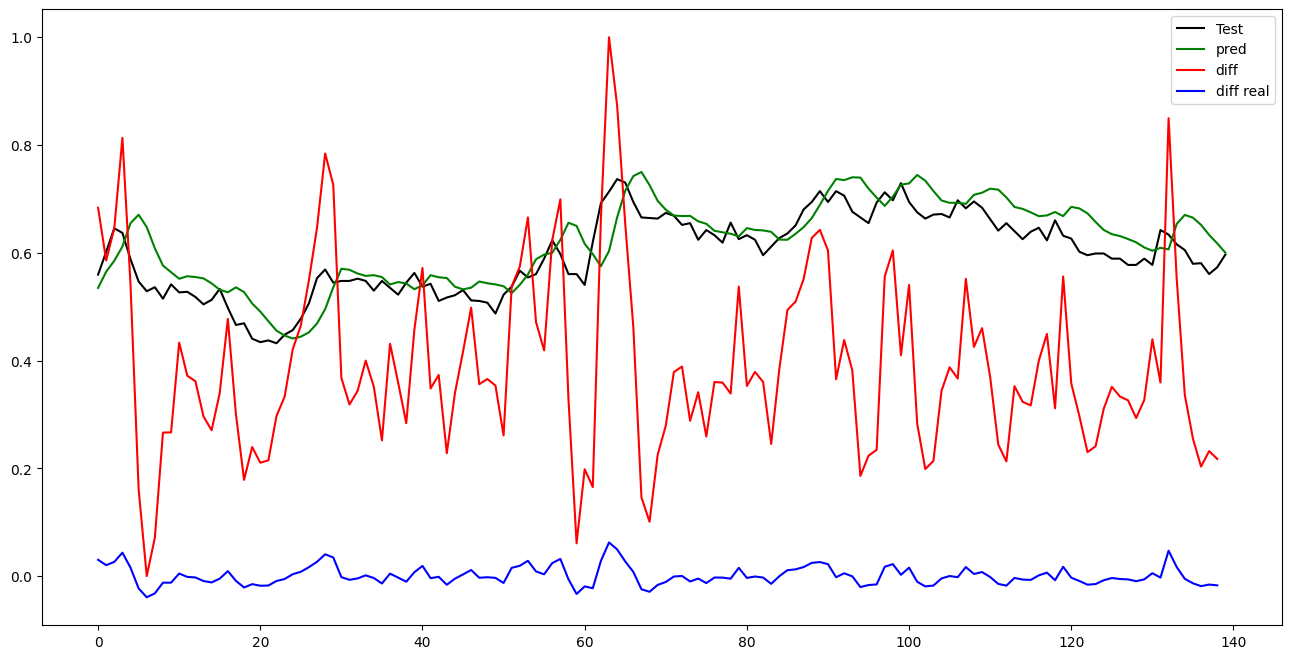

In [13]:
y_pred = model.predict(X_test)
deriv_y_pred = np.diff(y_pred, axis=0)
sc = MinMaxScaler(feature_range=(0,1))
deriv_y_pred_scaled = sc.fit_transform(deriv_y_pred)

plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.plot(deriv_y_pred_scaled, color = 'red', label = 'diff')
plt.plot(deriv_y_pred, color = 'blue', label = 'diff real')
plt.legend()
plt.show()

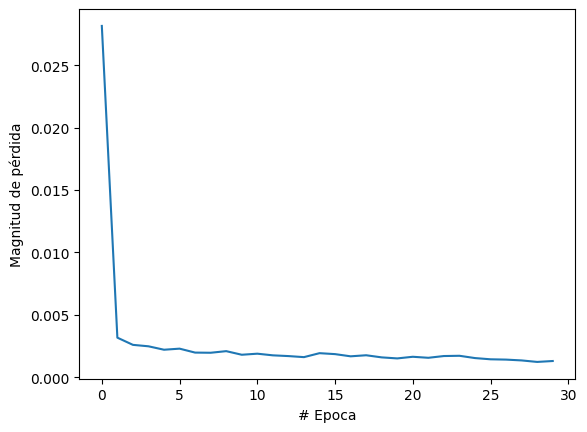

In [14]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(history.history["loss"])

In [15]:
# Obtener las predicciones del modelo
#y_pred = model.predict(X_test)

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)

# Imprimir el MSE
print('MSE:', mse)

MSE: 0.002116198874118409
